<a href="https://colab.research.google.com/github/ambideXtrous9/Variational-AutoEncoders-VAE-with-PyTorch/blob/main/VAE_implementation_in_PyTorch_Lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

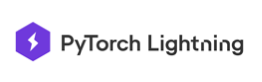

# VAE tutorial
Here we implement a VAE using Lightning.

⚡️ [The video tutorial is here](...)

⚡️ [Remember! we're always available for support on Slack](https://join.slack.com/t/pytorch-lightning/shared_invite/zt-f6bl2l0l-JYMK3tbAgAmGRrlNr00f1A)

---
# VAE Loss

The loss we'll be implementing for the VAE is called the ELBO.

$$
\color{red}{\min \mathbb{E}_{q}[ \log q(z|x) - \log p(z)]} - \color{blue}{\mathbb{E}_{q} \log p(x|z)}
$$

The first term is the KL-divergence and the second term the reconstruction.

For a full derivation and explanation see the next section

---
# Math

If you don't care about the derivation, please skip this part.

There are 2 ways to derive the VAE loss.
1. Using Jensen's inequality
2. Using KL divergence.

In this tutorial we'll use KL divergence.


## ELBO derivation

### What is the ELBO?
The result of this derivation is a loss called ELBO (evidence lower bound). The ELBO has two terms

Term 1: Reconstruction
$$
- \mathbb{E}_q \log p(x|z)
$$

Term 2: KL divergence
$$
\mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)}
$$

Together, these two terms define the ELBO:

$$
- \mathbb{E}_{q}  \log p(x|z) + \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)}
$$

### ELBO as a bound
Minimizing KL divergence is equivalent to maximizing ELBO (with some slack).

This means that ELBO is a lowerbound on KL divergence.
Here's a rendering of what we mean by this in abstract terms

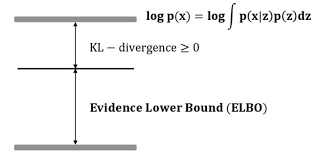

---
### How we get ELBO

Here's how we end up finding the ELBO.

First, remember we want to model a distribution over inputs, $ p(x) $. These can be images, etc...

We assume that there are factors that influence x but that we can't observe. We call these *latent* variables. We use $z$ to refer to these.

So, by using marginalization, we can rewrite this as

$$
p(x) = \int_z p(x|z)dz
$$

Marginalization is just fancy for summing over a variable.
Here's an example using a discrete probability distribution.


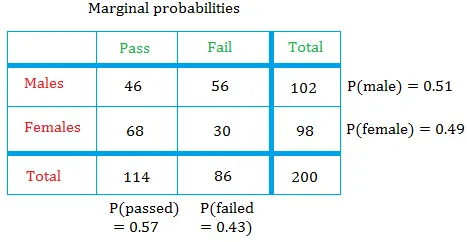




So, the joint model that uses $z$ variables to explain $x$ is defined by:

$$
p(x,z) = p(z|x)p(x)\\
\frac{p(x,z)}{p(x)} = p(z|x)
$$

But again, we find the $p(x)$ term at the bottom

To solve this we define $q(z|x)$ to approximate $p(z|x)$. $q$ is called the approximate posterior and $p$ the true posterior

Now this is starting to look like something we can do with machine learning. We have a source ($p$) and a target ($q$). We can treat this as an optimization problem where we parametrize $q$ (ie: a neural network) to try to get close to $p$ via gradient descent.

This is called variational inference (in general).

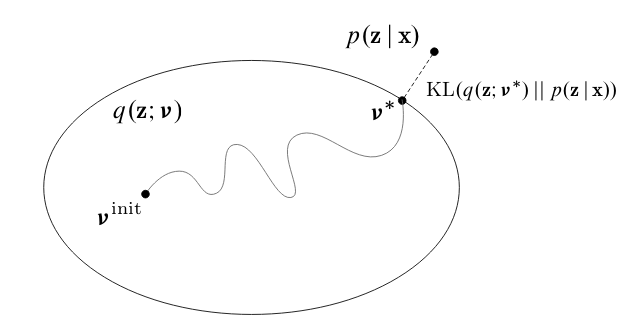

### KL divergence definition

The distance to minimize is called the KL divergence.
When we minimize the KL divergence, our $q$ will be an estimator of $p$.

This is the definition for the KL divergence between two distributions P, Q:

$$
D_{KL}(Q||P) = \sum Q \log \frac{Q}{P}
$$

We'll replace Q, P with our distributions $P = p(z|x)$ and $Q = q(z|x)$
$$
D_{KL}(q(z|x)||p(z|x)) = \sum q(z|x) \log \frac{q(z|x)}{p(z|x)}
$$

#### Sidenote about probability notation
I know using notation like $p(x)$ is confusing for those new to probability theory, but it is just a placeholder that stands for any distribution we want.
For example, $p(x)$ can be a Normal distribution, or a poisson, or any of the dozens of distributions available. It makes the math easier to manipulate simple letters with a few properties from probability theory

### ELBO derivation from KL(Q||P)
So, let's just play around with KL to see what comes out of the other end

\begin{align}
D_{KL}(q(z|x)||p(z|x)) &= \sum q(z|x) \log \frac{q(z|x)}{p(z|x)}\\
&= -\sum q(z|x) \log \frac{p(z|x)}{q(z|x)}\\
&= -\sum q(z|x)  \left[\log p(z|x) - \log q(z|x) \right]\\
&= -\sum q(z|x) \left[\log \frac{p(x|z)p(z)}{p(x)} - \log q(z|x) \right]\\
&= -\sum q(z|x) \left[\log p(x|z) + \log p(z) - \log p(x) - \log q(z|x) \right]\\
&= \sum q(z|x) \left[-\log p(x|z) - \log p(z) + \log p(x) + \log q(z|x) \right]\\
D_{KL}(q(z|x)||p(z|x)) - \sum q(z|x) \left[-\log p(x|z) - \log p(z) + \log q(z|x) \right] &= \log p(x)\\
-\sum q(z|x) \left[-\log p(x|z) + \log \frac{q(z|x)}{p(z)} \right] &= \\
-\mathbb{E}_{z \sim q(z|x)} \left[-\log p(x|z) + \log \frac{q(z|x)}{p(z)} \right] &=\\
-\mathbb{E}_{q} \left[-\log p(x|z) + \log \frac{q(z|x)}{p(z)} \right] &=\\
\mathbb{E}_{q} \left[\log p(x|z) - \log \frac{q(z|x)}{p(z)} \right] &=\\
D_{KL}(q(z|x)||p(z|x)) + \left[ \mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)} \right] &= \log p(x)\\
\end{align}

### Neural network loss
To maximize the ELBO, we can minimize the negative of the ELBO.

$$
\max \mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)} =
\min  - [\mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)}]
$$

### Monte carlo loss
\begin{align}
-\mathbb{E}_{q} \log p(x|z)  + \mathbb{E}_{q}[ \log q(z|x) - \log p(z)]&= \\
\mathbb{E}_{q}[ \log q(z|x) - \log p(z)] - \mathbb{E}_{q} \log p(x|z)&=
\end{align}


The end result is:

\begin{align}
D_{KL}(q(z|x)||p(z|x)) + \left[ \mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)} \right] &= \log p(x)
\end{align}


The first term is the original $D_{KL}$ we want to minimize, ($D_{KL}(q(z|x)||p(z|x))$). The second term is called the variational lower bound (ELBO).

$$
\max \mathcal{L} = \mathbb{E}_{q} \log p(x|z)  - \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)}
$$

Since $\log p(x)$ is a constant, and we want to minimize the $D_{KL}$ term, we can achieve the same by maximizing the ELBO.


So, the end goal is to minimize this function:

$$
\color{red}{\min \mathbb{E}_{q}[ \log q(z|x) - \log p(z)]} - \color{blue}{\mathbb{E}_{q} \log p(x|z)}
$$

### Other implementations
Here's where a disconnect might happen. For most tutorials, the tutorials assume that $p(z)$ (the prior) is gaussian and also assumes that $p(z|x)$ is also gaussian.

So, most tutorials end up with a KL divergence that looks like:

$$
-0.5 \sum{1 \log{(\sigma)} - \mu^2 - e^{\log{(\sigma)}}}
$$


But in our case, we won't do that because we want to retain the flexibility to modify distributions as needed.

And since we don't know the KL between all possible pairs of distributions, we'll actually just use monte-carlo sampling for this.

Recall that:
$$
\mathbb{E}_p = \frac{1}{N}\sum_{}p(x)
$$

So, anywhere we see $\mathbb{E}_q$ we will draw a sample from q and use it in the formula.

In [1]:
import torch

q = torch.distributions.Normal(2, 4)

z = q.rsample()
print(z)

tensor(4.3087)


## KL divergence intuition
Here we show the intuition of minimizing the KL

In [2]:
p = torch.distributions.Normal(0, 1)
q = torch.distributions.Normal(2, 4)

log_pz = p.log_prob(z)
log_qzx = q.log_prob(z)

print('log prob pz: ', log_pz, 'prob:', torch.exp(log_pz))
print('log prob qzx: ', log_qzx, 'prob:', torch.exp(log_qzx))

log prob pz:  tensor(-10.2012) prob: tensor(3.7125e-05)
log prob qzx:  tensor(-2.4718) prob: tensor(0.0844)


In [3]:
kl_divergence = log_qzx - log_pz
kl_divergence

tensor(7.7294)

now, if we manually move q closer to p, we see that this distrance has shrunk.

In [4]:
# old q = torch.distributions.Normal(2, 4)
q = torch.distributions.Normal(1, 2)

log_qzx = q.log_prob(z)
print('log prob qzx: ', log_qzx, 'prob:', torch.exp(log_qzx))

log prob qzx:  tensor(-2.9805) prob: tensor(0.0508)


new kl

In [5]:
new_kl_divergence = log_qzx - log_pz
new_kl_divergence

tensor(7.2207)

---
## Implementation walk-through
So, with our formula defined, let's start our implementation.


If you skipped the math and elbo derivation, remember we are implementing this loss (the ELBO)

$$
\color{red}{\min \mathbb{E}_{q}[ \log q(z|x) - \log p(z)]} - \color{blue}{\mathbb{E}_{q} \log p(x|z)}
$$

In [6]:
%%capture
! pip install pytorch-lightning
! pip install pytorch-lightning-bolts==0.2.5rc1

#### First 4 elements
The main 4 elements of a VAE are:
- encoder
- decoder
- mu
- sigma

mu, sigma are the parameters for the distributions in our formula.

Note: in our notation we say $q(z|x)$ where we assume $q$ to be a neural network. However, q is a neural network that DOES NOT GENERATE z. Instead it generates parameters FOR a distribution OVER z.

In [7]:
!pip install --quiet lightning-bolts

In [8]:
!pip install --quiet pytorch-lightning

In [9]:
from pl_bolts.models.autoencoders.components import resnet18_encoder,resnet50_decoder

/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapCon

In [10]:
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Sample z

In Lightning we define the model interactions and the core algorithm in the training_step.

For EDUCATIONAL purposes only, we are adding the training_step to the lightning module here instead of in the original class definition

The VAE algorithm goes like this:

1. Sample z

In [11]:
vae = VAE()

<ipython-input-10-82fb705615a5>:16: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/autoencoders/components.py:334: UnderReviewWarning: The feature ResNetEncoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/autoencoders/components.py:236: UnderR

In [12]:
# DATA
# we're pretending to have an image from cifar-10 (3 channels, 32x32 pixels)
x = torch.rand(1, 3, 32, 32)

print('image shape:', x.shape)

# GET Q(z|x) PARAMETERS
# encode x to get the mu and variance parameters
x_encoded = vae.encoder(x)
mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)

print('mu:', mu.shape)
print('log_var:', log_var.shape)

# SAMPLE Z from Q(Z|x)
std = torch.exp(log_var / 2)
q = torch.distributions.Normal(mu, std)
z = q.rsample()

print('z shape:', z.shape)

image shape: torch.Size([1, 3, 32, 32])
mu: torch.Size([1, 256])
log_var: torch.Size([1, 256])
z shape: torch.Size([1, 256])


In [13]:
zero = torch.zeros_like(mu)
one = torch.ones_like(std)
p = torch.distributions.Normal(zero, one)

#### decoding

The second part is reconstruction.

The decoder is going to take as input $z$ and it will generate PARAMETERS for a distribution from which to sample a reconstruction.

Note: Most tutorials use MNIST so the decoder generates BERNOULLI variables which can be used in a bernoulli distribution to sample a value for each pixel.

That's right, the decoder generates distribution parameters FOR EACH pixel. And since most tutorials use MNIST the outputs of the decoder will LOOK like a digit because those parameters are in the range 0-1 (which happens to be the same for black and white images).


But in our case, we'll actually use CIFAR-10 which are color images... so we need to do something more realistic:


In [14]:
x_hat = vae.decoder(z)
print(x_hat.shape)

torch.Size([1, 3, 32, 32])


#### reconstruction loss

You'll likely see the reconstruction loss using MSE like this in most tutorials about autoencoders.

However, MSE DOES not apply to Variational autoencoders

In [15]:
recon_loss = F.mse_loss(x_hat, x, reduction='none')
recon_loss = recon_loss.sum(-1).sum(-1).sum(-1)
print('wrong reconstruction loss', recon_loss)

wrong reconstruction loss tensor([2678.1475], grad_fn=<SumBackward1>)


Instead, the output of the decoder represents parameters for a distribution.

When the images are MNIST, the parameters (decoder output) can be considered bernoullis and thus you can use the pixel values of MNIST (because they are ones and zeros) to calculate the cross entropy (which is the "reconstruction loss").

But when dealing with color images, it is prefered to model each parameter out of the decoder as a gaussian.

In [16]:
# get the PARAMETERS for P(x|z)
x_hat = vae.decoder(z)
print('we have these many parameters for a distribution:', x_hat.shape)

# compute the probability of x under this n-dimensional distribution
log_scale = nn.Parameter(torch.Tensor([0.0]))
scale = torch.exp(log_scale)
dist = torch.distributions.Normal(x_hat, scale)
log_pxz = dist.log_prob(x)

print(log_pxz.shape)

# sum across channels, and all pixels (width, height)
# this gives the log probability of THIS particular IMAGE
log_pxz = log_pxz.sum(dim=(1, 2, 3))
print(log_pxz.shape)
print('reconstruction loss:', log_pxz.item())

recon_loss = log_pxz

we have these many parameters for a distribution: torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1])
reconstruction loss: -4162.052734375


#### kl divergence

Next we'll define the second term of the loss which is the KL divergence.

Now, we don't want to compute the KL divergence analytically, so we'll instead use the monte carlo estimate.

$$
= \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)}\\
= \mathbb{E}_{q} [\log q(z|x) - \log{p(z)}]
$$

To code this, we'll need to be able to get the probability of z under each of $p(z)$ and $q(z|x)$.

This means we don't need to know what the distribution is, but only sample from it.


In [17]:
# 1. define the first two probabilities (in this case Normal for both)
p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
q = torch.distributions.Normal(mu, std)

# 2. get the probabilities from the equation
log_qzx = q.log_prob(z)
log_pz = p.log_prob(z)

print(log_qzx.shape, log_pz.shape)

# 3. calculate the KL
kl = (log_qzx - log_pz)

# 4. this bit is a bit tricky. Since these are log probabilities
# we can sum all the individual dimensions to give us the multi-dimensional
# probability
kl = kl.sum(-1)
print(kl)

torch.Size([1, 256]) torch.Size([1, 256])
tensor([31.8195], grad_fn=<SumBackward1>)


#### ELBO

So, the full elbo is:

In [18]:
elbo = (kl - recon_loss)
print('kl:', kl.mean())
print('log likelihood (reconstruction loss):', recon_loss.mean())
print('elbo: ', elbo.mean())

kl: tensor(31.8195, grad_fn=<MeanBackward0>)
log likelihood (reconstruction loss): tensor(-4162.0527, grad_fn=<MeanBackward0>)
elbo:  tensor(4193.8721, grad_fn=<MeanBackward0>)


# Full Implementation
So, the full implementation is as follows.

In [10]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint

In [16]:
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))
        
    def forward(self,x):
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = vae.decoder(z)
        
        return mu,std,x_hat,z
        

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl
    
    def loss_function(self,mu,std,x,x_hat,z):
        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)
        # kld loss
        kl = self.kl_divergence(z, mu, std)
        # toatal loss
        elbo = (kl - recon_loss)
        
        return {'elbo': elbo.mean(),
                'kl': kl.mean(),
                'recon_loss': recon_loss.mean()}
                

    def training_step(self, batch, batch_idx):
        x, _ = batch
        mu,std,x_hat,z = self.forward(x)
        total_loss = self.loss_function(mu,std,x,x_hat,z)
        return total_loss['elbo']
    
    def validation_step(self, batch, batch_idx):
        x, _ = batch
        mu,std,x_hat,z = self.forward(x)
        total_loss = self.loss_function(mu,std,x,x_hat,z)
        self.log('val_loss', total_loss['elbo'], on_step=True, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)


Let's use CIFAR-10 already split up and transformed.

The Lightning Datamodule has 3 dataloaders, train, val, test

In [17]:
from pl_bolts.datamodules import CIFAR10DataModule

datamodule = CIFAR10DataModule(batch_size=128)

Now we train!

In [18]:
class ImageSampler(pl.Callback):
    def __init__(self):
        super().__init__()
        self.img_size = None
        self.num_preds = 16

    def on_train_epoch_end(self, trainer, pl_module, outputs):
        figure(figsize=(8, 3), dpi=300)

        # Z COMES FROM NORMAL(0, 1)
        rand_v = torch.rand((self.num_preds, pl_module.hparams.latent_dim), device=pl_module.device)
        p = torch.distributions.Normal(torch.zeros_like(rand_v), torch.zeros_like(rand_v))
        z = p.rsample()

        # SAMPLE IMAGES
        with torch.no_grad():
            pred = pl_module.decoder(z.to(pl_module.device)).cpu()

        # UNDO DATA NORMALIZATION
        normalize = cifar10_normalization()
        mean, std = np.array(normalize.mean), np.array(normalize.std)
        img = make_grid(pred).permute(1, 2, 0).numpy() * std + mean

        # PLOT IMAGES
        trainer.logger.experiment.add_image('img',torch.tensor(img).permute(2, 0, 1), global_step=trainer.global_step)

In [19]:
pl.seed_everything(42)

checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints',
    filename = 'BestVAE',
    save_top_k = 1,
    verbose = True,
    monitor = 'val_loss',
    mode = 'min'
)

vae = VAE()


trainer = pl.Trainer(accelerator='gpu',
                     devices=-1,
                     max_epochs=30,
                     check_val_every_n_epoch=5,
                     callbacks=[checkpoint_callback])

Global seed set to 42
/tmp/ipykernel_61578/2136447856.py:16: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
/tmp/ipykernel_61578/2136447856.py:17: UnderReviewWarning: The feature resnet18_decoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.decoder = resnet18_decoder(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [20]:
trainer.fit(model=vae, datamodule=datamodule)

Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11.2 M
1 | decoder | ResNetDecoder | 8.6 M 
2 | fc_mu   | Linear        | 131 K 
3 | fc_var  | Linear        | 131 K 
------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.228    Total estimated model params size (MB)


/home/sushovan/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:  12%|█▏        | 39/313 [00:17<02:05,  2.19it/s, loss=2.93e+03, v_num=9]

/home/sushovan/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Plot an image

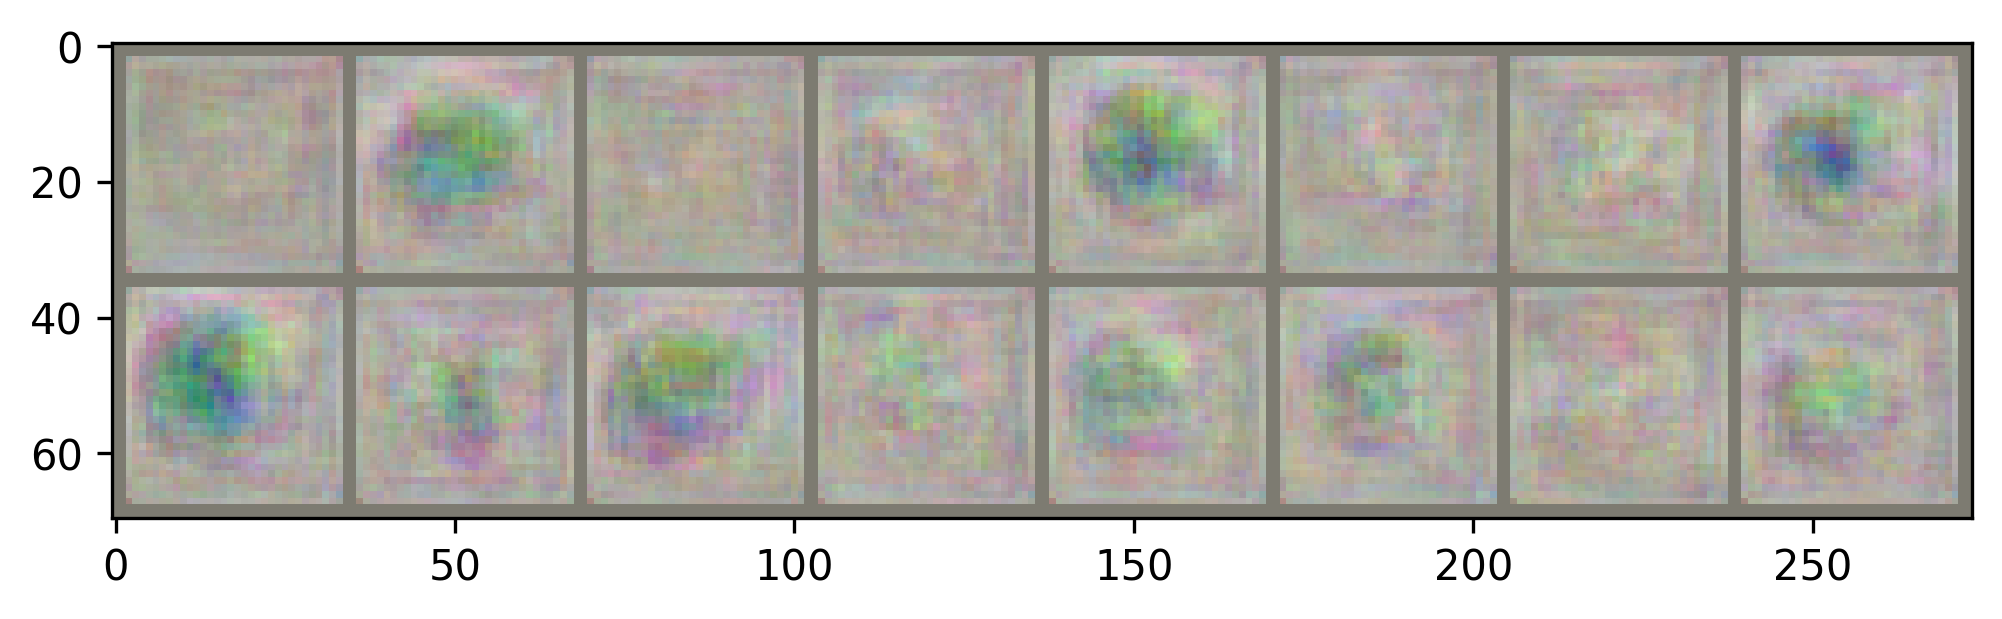

In [21]:
figure(figsize=(8, 3), dpi=300)

# Z COMES FROM NORMAL(0, 1)
num_preds = 16
rand_v = torch.rand(num_preds, vae.hparams.latent_dim)
p = torch.distributions.Normal(torch.zeros_like(rand_v), torch.ones_like(rand_v))
z = p.rsample()

# SAMPLE IMAGES
with torch.no_grad():
    pred = vae.decoder(z.to(vae.device)).cpu()

# UNDO DATA NORMALIZATION
normalize = cifar10_normalization()
mean, std = np.array(normalize.mean), np.array(normalize.std)
img = make_grid(pred).permute(1, 2, 0).numpy() * std + mean

# PLOT IMAGES
imshow(img);